# TensorFlow2.0教程-Boosted trees

本教程是使用决策树和tf.estimator API训练Gradient Boosting模型的端到端演练。 Boosted Trees模型是回归和分类中最受欢迎和最有效的机器学习方法之一。 这是一种集合技术，它结合了几种树模型的预测。

Boosted Trees模型受到许多机器学习从业者的欢迎，因为它们可以通过最小的超参数调整实现令人印象深刻的性能。

## 1.加载泰坦尼克数据集


In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
from IPython.display import clear_output

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [2]:
import tensorflow as tf
tf.random.set_seed(123)

数据集由训练集和评估集组成：

- `dftrain`和`y_train`是*training set*  - 模型用来学习的数据。
- 模型根据*eval set*，`dfeval`和`y_eval`进行测试。

数据集设定的特征如下：
<table>
  <tr>
    <th>Feature Name</th>
    <th>Description</th> 
  </tr>
  <tr>
    <td>sex</td>
    <td>Gender of passenger</td> 
  </tr>
  <tr>
    <td>age</td>
    <td>Age of passenger</td> 
  </tr>
    <tr>
    <td>n_siblings_spouses</td>
    <td># siblings and partners aboard</td> 
  </tr>
    <tr>
    <td>parch</td>
    <td># of parents and children aboard</td> 
  </tr>
    <tr>
    <td>fare</td>
    <td>Fare passenger paid.</td> 
  </tr>
    <tr>
    <td>class</td>
    <td>Passenger's class on ship</td> 
  </tr>
    <tr>
    <td>deck</td>
    <td>Which deck passenger was on</td> 
  </tr>
    <tr>
    <td>embark_town</td>
    <td>Which town passenger embarked from</td> 
  </tr>
    <tr>
    <td>alone</td>
    <td>If passenger was alone</td> 
  </tr>
</table>

## 2.探索数据

In [3]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
dftrain.shape[0], dfeval.shape[0] # 训练集，验证集数量

(627, 264)

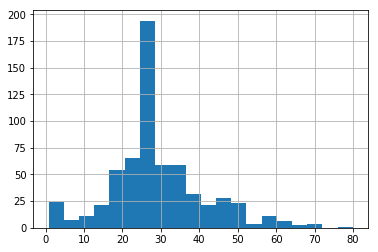

In [7]:
# 年龄分布
dftrain.age.hist(bins=20)

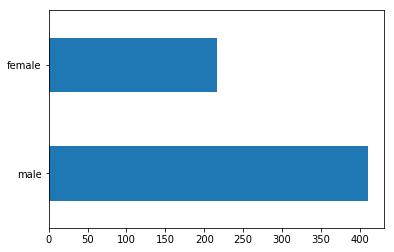

In [8]:
# 男女比例
dftrain.sex.value_counts().plot(kind='barh')

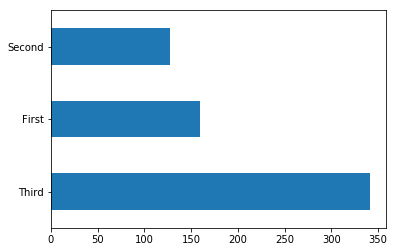

In [9]:
# 大部分为三等顾客
dftrain['class'].value_counts().plot(kind='barh')

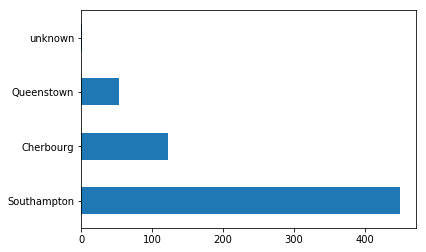

In [11]:
# 大多数乘客从南安普敦出发。
dftrain['embark_town'].value_counts().plot(kind='barh');

Text(0.5, 0, '% survive')

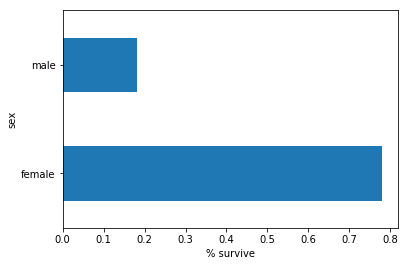

In [12]:
# 与男性相比，女性存活的机率要高得多。 这显然是该模型的预测特征
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## 3.构造输入特征

In [13]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
  
def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # Need to one-hot encode categorical features.
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

可以查看要素列生成的转换。 例如，以下是在单个示例中使用`indicator_column`时的输出：

In [14]:
example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"


W0331 19:59:16.792093 140069985818368 deprecation.py:323] From /home/czy/anaconda3/envs/tf2_0/lib/python3.6/site-packages/tensorflow/python/ops/lookup_ops.py:1347: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0331 19:59:16.879169 140069985818368 deprecation.py:323] From /home/czy/anaconda3/envs/tf2_0/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4307: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0331 19:59:16.880531 140069985818368 deprecation.py:323] From /home/czy/anaconda3/envs/tf2_0/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4362: VocabularyListCategoricalColumn._num_buckets (from 

One-hot encoded:  [[0. 0. 1.]]


可以一起查看所有要素列转换：

In [15]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

W0331 20:00:18.112254 140069985818368 deprecation.py:323] From /home/czy/anaconda3/envs/tf2_0/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

接下来，需要创建输入函数。 这些将指定如何将数据读入我们的模型以进行训练和推理。 我们使用[`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data)
API中的`from_tensor_slices`方法直接从Pandas读取数据。 这适用于较小的内存数据集。 对于较大的数据集，tf.data API支持各种文件格式（包括[csv](https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset))

In [16]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).    
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

## 4.训练和验证模型

在训练Boosted Trees模型之前，让我们首先训练一个线性分类器（逻辑回归模型）。 最好的做法是从更简单的模型开始建立基准。

In [17]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


接下来让我们训练一下Boosted Trees模型。 对于增强树，支持回归（BoostedTreesRegressor）和分类（BoostedTreesClassifier）。 由于目标是预测一个类，所以我们使用BoostedTreesClassifier。

In [18]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset. 
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.829545
accuracy_baseline         0.625000
auc                       0.873003
auc_precision_recall      0.858218
average_loss              0.410594
label/mean                0.375000
loss                      0.410594
precision                 0.793478
prediction/mean           0.381616
recall                    0.737374
global_step             100.000000
dtype: float64


用训练好的模型进行预测

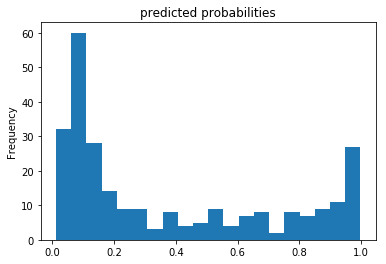

In [20]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

观察roc得分

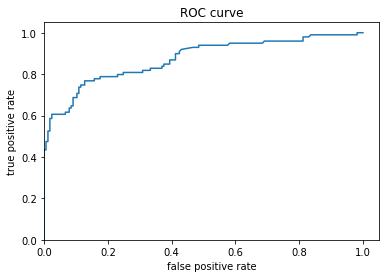

In [21]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,);